In [ ]:
import os 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tensorflow.keras.saving import load_model
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # It will pad the sequences to same length
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding , Dropout, add

# Visualizing the Images with Captions 

In [ ]:
image_path='../input/flickr8k/Images'
caption_path='../input/flickr8k/captions.txt'

caption_data= pd.read_csv('../input/flickr8k/captions.txt')
caption_data.head(10)

In [31]:
count=1
target_size=(224,224,3)

def read_image(image_path,target_size):
    img=load_img(image_path,target_size=target_size)
    img=img_to_array(img)
    img=img/255
    
    return img
def img_display(data,target_size):
    data= data.reset_index(drop=True)
    plt.figure(figsize=(10,10))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,3,n)
        image=read_image(image_path+'/'+data.image[i],target_size=target_size)
        plt.imshow(image)
        plt.axis("off")
        

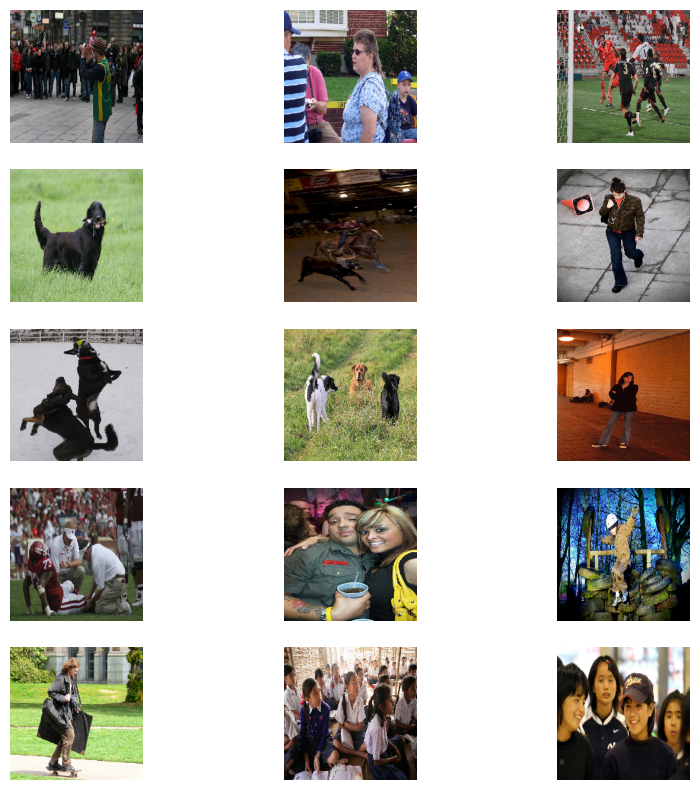

In [32]:
img_display(caption_data.sample(15),target_size)

# VGG Model
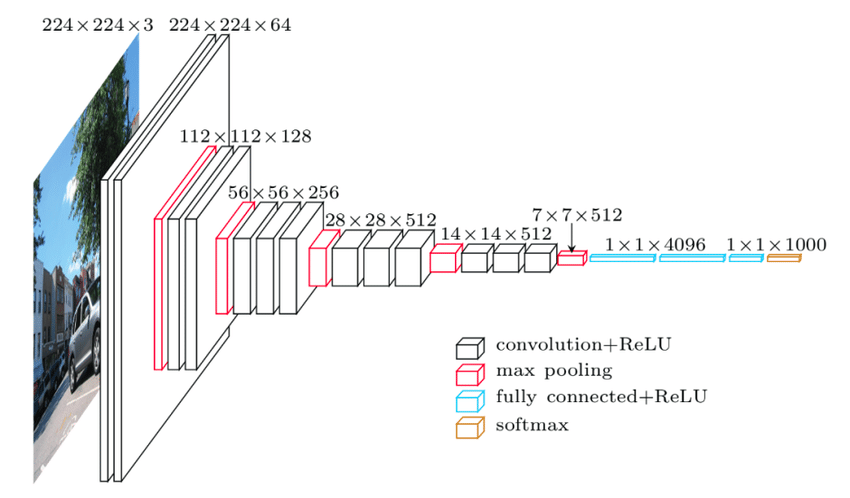


# Extract Image Features

In [33]:
model=VGG16()
#Ignoring the last prediction layer in the VGG16() model
model=Model(inputs=model.inputs,outputs=model.layers[-2].output) 
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Extracting features from images
features={}
directory=image_path

for img_name in tqdm(os.listdir(directory)):
    #load the image from the file
    img_path=directory+'/'+img_name
    
    #Height and Width of 224 units respectively
    image=load_img(img_path,target_size=(224,224))
    
    #Convert image pixels to numpy array
    image=img_to_array(image)
    
    #Reshape data for Model
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    #Pre-process the image for VGG
    image=preprocess_input(image)
    
    #Extract Features
    feature =model.predict(image,verbose=0)
    
    #Get Image_ID
    image_id=img_name.split(".")[0]
    
    # Store Features
    features[image_id]=feature

In [ ]:
print("Extracted Features: "+str(len(features)))
# Save features to file
WORKING_DIR='/kaggle/working'
pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))
print("Features Saved")

In [34]:
# load features from pickle
with open(os.path.join('/kaggle/input/dataset', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Prepare Text Data

In [35]:
# 
with open(caption_path,'r') as f:
    next(f) # To skip first line
    captions_doc = f.read()

**Create Mapping of Image to Captions**

In [36]:
mapping ={}

for line in tqdm(captions_doc.split("\n")):
    #Split the line by comma
    tokens = line.split(',')
    # Ignoring small words
    if len(line)<2:
        continue
    image_id, caption =tokens[0], tokens[1:]
    # Remove filename from image_id (.jpg)
    image_id = image_id.split('.')[0]
    # Convert caption back to string
    caption=" ".join(caption)
    # Create list if needed for more than one caption for same image
    if image_id not in mapping:
        mapping[image_id]=list()
     # Store the caption
    mapping[image_id].append(caption)      

  0%|          | 0/40456 [00:00<?, ?it/s]

In [37]:
print('Mapping done: ',len(mapping))

Mapping done:  8091


 Cleaning the Captions Text
* Converting all words to lowercase
* Removing all punctuation
* Remove all words that are one character or less in length
* Remove all words with numbers in them

In [38]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption=captions[i]
            # Preprocessing steps
            # Convert to Lowercase
            caption = caption.lower()
            #replace digits,special chars, multiple space with blank and single space respectively
            caption=caption.replace('[^A-Za-z]','')
            caption= caption.replace('\s+',' ')
            #add start and end tags
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i] = caption

In [12]:
#before
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [39]:
clean(mapping)
# after
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [54]:
def save_list_to_file(lst, file_path):
    with open(file_path, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')
            
def read_list_from_file(file_path):
    lst = []
    with open(file_path, 'r') as file:
        for line in file:
            lst.append(line.strip())
    return lst


In [55]:
# Convert the loaded captions into a vocabulary of word
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
print('No of Captions:',len(all_captions))
#Tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
print('Vocabulary Size:',vocab_size)
# Maximum length of caption available to be used to pad the sequence
max_length=max(len(caption.split()) for caption in all_captions)
print('Max Caption Length:',max_length)
save_list_to_file(all_captions,os.path.join(WORKING_DIR,'all_captions.txt'))

No of Captions: 40455
Vocabulary Size: 8485
Max Caption Length: 35


Saving Captions to a file

In [41]:
def save_captions(mapping,filename):
    lines=list()
    for key, captions_list in mapping.items():
        for caption in captions_list:
            lines.append(key+' '+caption)
            data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
# Saving Captions
save_captions(mapping,'captions_final.txt')

# Train Test Split

In [42]:
image_ids =list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test= image_ids[split:]
print('Training Set: ',len(train))
print('Test Set: ',len(test))

Training Set:  7281
Test Set:  810


In [17]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y= list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            #processing each caption
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq,out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                    # Encode Output Sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    # Store the sequences 
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                if n==batch_size:
                    X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                    yield[X1,X2],y
                    X1, X2, y= list(), list(), list()
                    n=0

# Model Creation

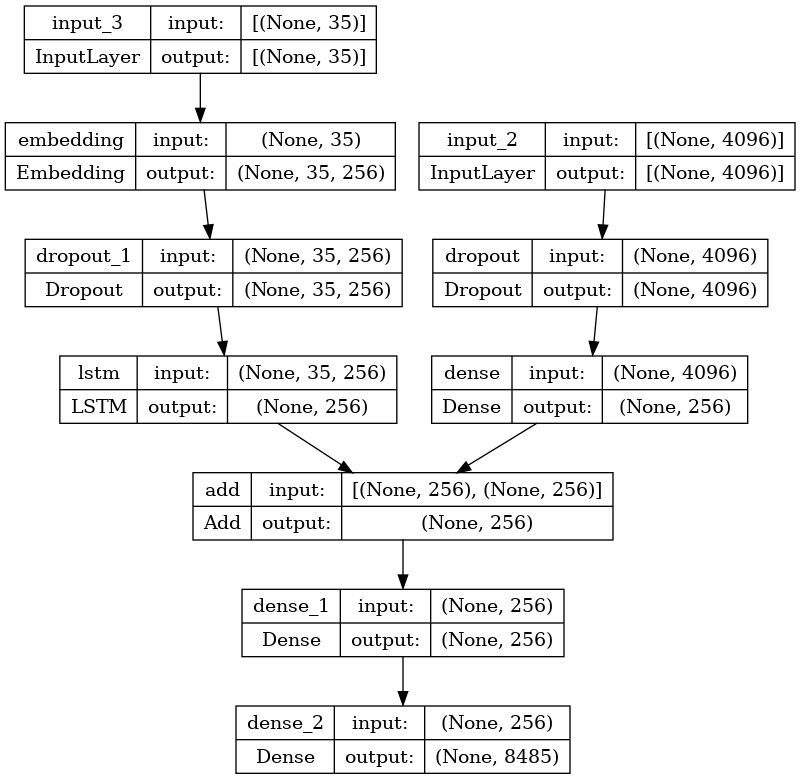

In [18]:
# Encoder Model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation="relu")(fe1)
    
# Sequence Feature Layer
inputs2 = Input(shape=(max_length,))
se1= Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 =add([fe2,se3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs =outputs=Dense(vocab_size,activation='softmax')(decoder2)

model= Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Plotting the Model
plot_model(model, show_shapes = True)

# Training the Model

In [ ]:
epochs=20
batch_size=32
steps=  len(train)//batch_size

for i in range(epochs):
    # Create Data Generator
    generator= data_generator(train,mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
# Saving the model
model.save(WORKING_DIR+'/model.h5')

In [43]:
# Loading the model
model=load_model('/kaggle/input/dataset'+'/model.h5')

# Generate Captions for an Image 

In [44]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [45]:
def predict_caption(model,image,tokenizer,max_length):
    # add start tag for generation process 
    in_text='startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence= pad_sequences([sequence],max_length)
        # Predict the next word
        yhat = model.predict([image,sequence],verbose=0)
        # Get the index with the highest probability
        yhat=np.argmax(yhat)
        # Convert the index to word
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        # Append word as input
        in_text+= " "+word
        # Stop if we reach end tag
        if word=='endseq':
            break
    return in_text
        

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with Test data
actual, predicted =list(),list()

for key in tqdm(test):
    # Get Actual Captions
    captions=mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    # Split into words
    actual_captions =[caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# Calculating the BLEU(Bilingual Evaluation Understudy) Score
print("BLEU-1 %f"%corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2 %f"%corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 0.518091
BLEU-2 0.294355


# Visualizing the result

In [47]:
WORKING_DIR='/kaggle/working'
def save_list_to_file(lst, file_path):
    with open(file_path, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')
save_list_to_file(predicted,os.path.join(WORKING_DIR,'predict.txt'))
save_list_to_file(actual,os.path.join(WORKING_DIR,'actual.txt'))

In [48]:
from PIL import Image

def img_display_with_captions(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_path,image_name)
    image = Image.open(img_path)
    y_pred= predict_caption(model,features[image_id],tokenizer,max_length)
    plt.imshow(image)
    print(y_pred)
    plt.axis("off")
        

    

startseq two people playing on beach endseq


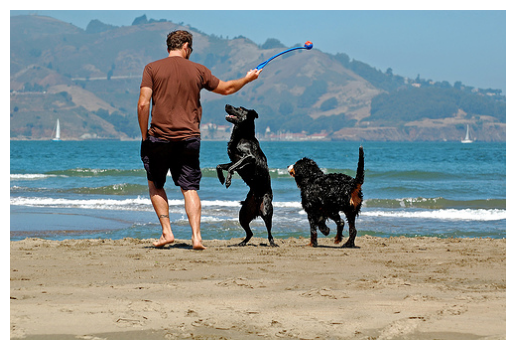

In [49]:
img_display_with_captions('1075867198_27ca2e7efe.jpg')

startseq young boy is playing in fountain endseq


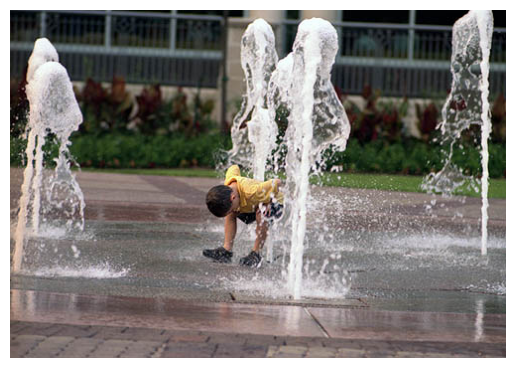

In [50]:
img_display_with_captions('1095476286_87d4f8664e.jpg')

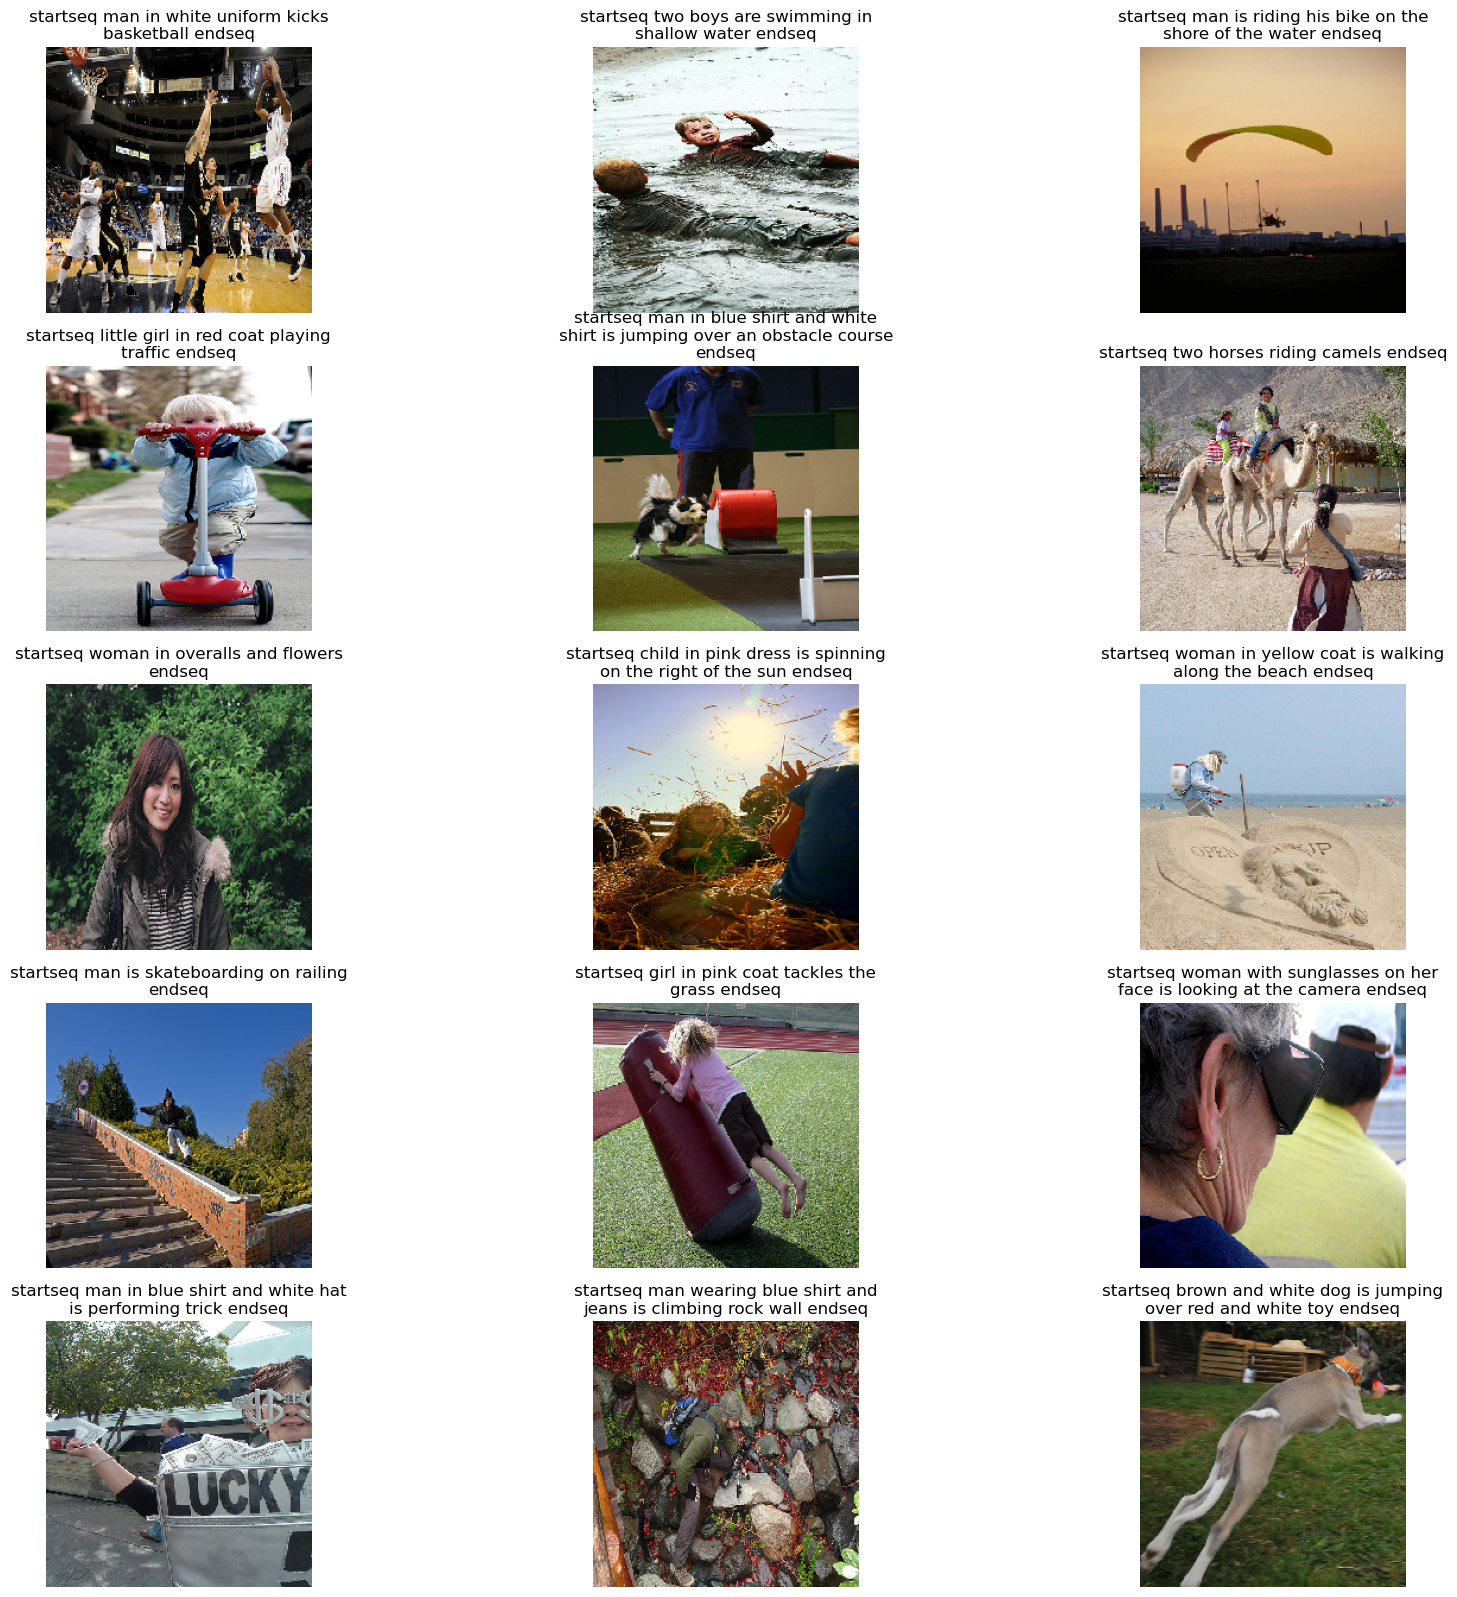

In [51]:
from textwrap import wrap
def list_to_string(l):
    str1=""
    for w in l:
        str1 += w
    return str1
def img_display(data,target_size):
    data= data.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,3,n)
        image=read_image(image_path+'/'+data.image[i],target_size=target_size)
        image_id= list_to_string(data.image[i]).split('.')[0]
        y_pred= predict_caption(model,features[image_id],tokenizer,max_length)
        plt.title("\n".join(wrap(y_pred, 40)))
        plt.imshow(image)
        plt.axis("off")
img_display(caption_data.sample(15),target_size)
        

# Deployment

In [59]:
%%writefile app1.py
import streamlit as st
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np
import cv2
from PIL import Image


# Obtained earlier 
MAX_LENGTH=35
    
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def read_list(file_path):
    lst = []
    with open(file_path, 'r') as file:
        for line in file:
            lst.append(line.strip())
    return lst

def preprocess_image(img):
    # Resize the Image
    img = img.resize((224,224))
    # Convert the image to a Numpy Array
    img_arr= np.array(img)
    # Normalizing pixel values
    image= img_arr/255.0
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    return image

def predict_caption(model,image,max_length=MAX_LENGTH):
    all_captions = read_list('/kaggle/input/dataset/all_captions.txt')
    #Tokenize the text
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    # add start tag for generation process 
    in_text='startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence= pad_sequences([sequence],max_length)
        # Predict the next word
        yhat = model.predict([image,sequence],verbose=0)
        # Get the index with the highest probability
        yhat=np.argmax(yhat)
        # Convert the index to word
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        # Append word as input
        in_text+= " "+word
        # Stop if we reach end tag
        if word=='endseq':
            break
    return in_text

def generate_clean_caption(in_text):
    # Split the string into a list of words
    words = in_text.split()
    # Join all words except the first and last
    result = ' '.join(words[1:-1])  
    return result
    
    

## Layout ##
rad = st.sidebar.radio("Navigation",["Home","Caption Generator"])


if rad=="Home":
    st.title("Image Caption Generator")
    st.subheader("By Hardik Pahwa")
    st.markdown("""Upload an Image in the Caption Generator page to generate Caption""")
    
    st.image("sample.jpg")
    
elif rad=="Caption Generator":
    st.write("""
            # Caption Generation
    """)
   
    with st.spinner("Loading Model..."):
        model = load_model("/kaggle/input/dataset/model.h5")
        
    file = st.file_uploader("Upload an Image")
    st.write(file)
    st.set_option('deprecation.showfileUploaderEncoding', False)
        
    if file != None:
        image = Image.open(file)
        st.image(image,caption="Uploaded Image",use_column_width=True)
        #  Prepocessing the Image
        image=preprocess_image(image)
        
        in_text=predict_caption(model,image)
        # Removing Startseq and Endseq
        caption= generate_clean_caption(in_text)
        
        # Display the Caption
        st.write('Generated Caption:')
        st.write(caption)
    else:
        st.write("No file uploaded")

Writing app1.py
